In [1]:
import pandas as pd
import os 

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda

import pickle

from utils.network_analysis import *
from utils.neural_embedding import *

In [2]:
# Set thresholds for kout and kin
congressperson_kout=1
followee_kin=1
network = 'combined'
embedding_dimension = 10

In [3]:
# Parameters
congressperson_kout = 1
followee_kin = 10
network = "senate"
embedding_dimension = 5


## **1. Process training data**

#### **1.1 Read and process edgelist CSVs**

In [4]:
filepath=  f"data/processed/edgelists/{network}_edgelist_kout{congressperson_kout}_kin{followee_kin}.csv"
samples, feature_index_map, label_index_map = trainingDataRead(filepath)

8105 samples
55 features and 478 labels


#### **1.2 Load training data into Dataset class**

In [5]:
#----- DEFINE TRANSFORMS FOR USER -> ONE-HOT ENCODING VECTORS -----#

# Define the transform (one-hot encoding) for the input data
transform = Lambda(lambda y: torch.zeros(len(feature_index_map), dtype=torch.float).scatter_(
    0, torch.tensor(feature_index_map[y]), value=1))

# Define the target_transform (one-hot encoding) for the output labels
target_transform = Lambda(lambda y: torch.zeros(len(label_index_map), dtype=torch.float).scatter_(
    0, torch.tensor(label_index_map[y]), value=1))


# Load in training data
dataset= FollowingDataset(data = samples, transform=transform ,target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

#### **1.3 Define function to retrieve text label from one-hot encoding**

In [6]:
def one_hot_to_label(one_hot_vector, label_to_index):
    """Get twitter username from a given one-hot encoding
    Args:
        - one_hot_vector (torch.Tensor) : one-hot encoded tensor representing user
        - label_to_index (dict) : dictionary of structure {username : int} representing username -> integer mapping used in data preprocessing
    Returns:
        - user (str) : username of user represented by the one-hot vector
    """
    index = torch.argmax(one_hot_vector).item()
    index_to_label = {idx: label for label, idx in label_to_index.items()}
    user = index_to_label[index]
    return user

## **2. Network training**

#### **2.1 Get Device for Training**

In [7]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


#### **2.2 Define the Class for the Neural Network**

In [8]:
# Custom network class. Consists of an input layer of d dimensions, a hidden layer of n dimensions, and an output layer of m dimension. Can specify if bias parameter is used in layers.

class FollowingNetwork(nn.Module):
    def __init__(self, d=108, n=20,m=115306, bias=False):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(d, n, bias=bias), # Linear embedding layer with n=20 nodes
            nn.Linear(n,m, bias=bias), # Final output linear layer, with m=115,306 nodes 
        )

    def forward(self, x):
        logits = self.linear_stack(x) # pass data x through layers defined in nn.Sequential. Return raw logits
        return logits

#### **2.3 Define hyperparameters and overheads**

In [9]:
# Create instance of FoolowingNetwork and move to device
d = len(feature_index_map) 
m = len(label_index_map)
n = embedding_dimension # Embedding dimension

model = FollowingNetwork(d=d, n=n, m=m, bias=False).to(device)
print(model)

# Set hyperparameters
epochs = 15
batch_size = 128
learning_rate = 0.001

# Initialise the loss function
loss_fn = nn.CrossEntropyLoss()

# Initialise optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

FollowingNetwork(
  (linear_stack): Sequential(
    (0): Linear(in_features=55, out_features=5, bias=False)
    (1): Linear(in_features=5, out_features=478, bias=False)
  )
)


#### **2.4 Perform training**

Epoch 1
-------------------------------
loss: 6.168937  [  128/ 8105]


Epoch 2
-------------------------------
loss: 6.166113  [  128/ 8105]
Epoch 3
-------------------------------


loss: 6.170964  [  128/ 8105]
Epoch 4
-------------------------------
loss: 6.170160  [  128/ 8105]


Epoch 5
-------------------------------
loss: 6.168355  [  128/ 8105]


Epoch 6
-------------------------------
loss: 6.167546  [  128/ 8105]
Epoch 7
-------------------------------
loss: 6.162511  [  128/ 8105]


Epoch 8
-------------------------------
loss: 6.162839  [  128/ 8105]
Epoch 9
-------------------------------
loss: 6.162128  [  128/ 8105]


Epoch 10
-------------------------------
loss: 6.157894  [  128/ 8105]
Epoch 11
-------------------------------
loss: 6.166934  [  128/ 8105]


Epoch 12
-------------------------------
loss: 6.151976  [  128/ 8105]
Epoch 13
-------------------------------
loss: 6.157241  [  128/ 8105]


Epoch 14
-------------------------------
loss: 6.145837  [  128/ 8105]
Epoch 15
-------------------------------
loss: 6.147320  [  128/ 8105]


Done!


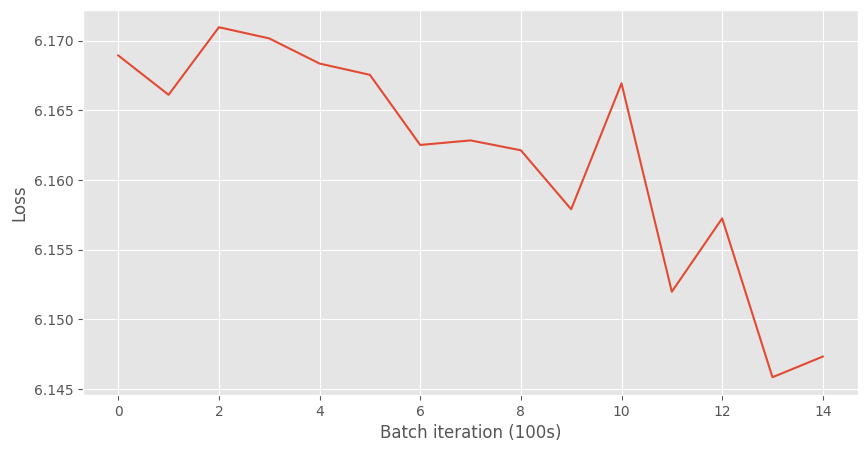

In [10]:
# Train over epochs
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_losses = train_loop(dataloader, model, loss_fn, optimizer, device, batch_size)
    losses += epoch_losses
print("Done!")

#chamber = filepath.split('_edgelist')[0].split('processed/')[-1]
model_name = f'model_{network}_{filepath.split('edgelist_')[-1].split('.csv')[0]}_{n}.pth'
# Save trained model
torch.save(model, 'models/' + model_name)

def plotLosses(losses):
    with plt.style.context("ggplot"):
        plt.figure(figsize=(10,5))
        plt.plot(range(0,len(losses)), losses)
        plt.xlabel('Batch iteration (100s)')
        plt.ylabel('Loss')
        plt.show()

plotLosses(losses=losses)

## **3. Get embeddings from model**

In [11]:
# Load model and get first layer weights
model = torch.load('models/' + model_name)
first_layer_weights = model.linear_stack[0].weight.data.T

# Pair embedding vectors with text usernames
embeddings = [i.cpu().numpy() for i in first_layer_weights]
embeddings_dct = dict(zip(list(feature_index_map.keys()),embeddings))

embeddings_name = model_name.replace('model_', 'embedding_').replace('.pth', '.pkl')
# Pickle/save embedding dictionary
with open("data/processed/embeddings/" + embeddings_name, "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(embeddings_dct, f)

/var/folders/tg/yjf26c0j7r30zkzr43n_9hbc0000gn/T/ipykernel_20853/941759662.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/' + model_name)
